In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from src.ParticleCloud import EdgeConvolutionLayer, ChannelWiseGlobalAvaragePooling
from src.Preprocessing import JetProcessingParticleCloud
from src.Particle import ParticleType
from sklearn.model_selection import train_test_split

In [2]:
data_gluon = pd.read_csv('../../Data/g_jets.csv', header=None, sep=' ')
data_quark = pd.read_csv('../../Data/q_jets.csv', header=None, sep=' ')
data_top = pd.read_csv('../../Data/t_jets.csv', header=None, sep=' ')

In [3]:
# joinning data frames
all_jets = pd.concat([data_top, data_quark.loc[:int(len(data_quark)/2), :], data_gluon.loc[:int(len(data_quark)/2), :]], axis=0)
all_jets.reset_index(drop=True, inplace=True)
# defining the dictionary with the order of jets in the full data frame
jets_order = {
    ParticleType.Top: (0, len(data_top) - 1), 
    ParticleType.LightQuark: (len(data_top), len(all_jets) - 1),
}

In [4]:
jet_preprocessing = JetProcessingParticleCloud()
X = jet_preprocessing.transform(X=all_jets.to_numpy(), y=jets_order)
y = jet_preprocessing.jet_labels

In [5]:
# Dividing the data into trainning, validation, and test
# diving the set into trainning, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

print(f"Size of the Training set: {len(X_train)}")
print(f"Size of the Validation set: {len(X_val)}")
print(f"Size of the Test set: {len(X_test)}")

Size of the Training set: 251881
Size of the Validation set: 44450
Size of the Test set: 52294


In [6]:
# first we need the MLP
# just including one layer
mlp_jets = keras.Sequential([
    keras.layers.InputLayer(shape=[6]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
])

mlp_jets_2 = keras.Sequential([
    # always remember that the input is 2x the output of the previous mlp
    keras.layers.InputLayer(shape=[64]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
])

jet_tag_model = keras.Sequential([
    keras.layers.InputLayer(shape=(30, 4)),
    EdgeConvolutionLayer(mlp=mlp_jets, k_neighbors=5, final_index_coord=2, max_number_particles=30),
    EdgeConvolutionLayer(mlp=mlp_jets_2, k_neighbors=5, final_index_coord=8, max_number_particles=30),
    ChannelWiseGlobalAvaragePooling(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(rate=0.05),
    keras.layers.Dense(2, activation='softmax')
])

jet_tag_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ edge_convolution_layer          │ (None, 30, 33)         │         1,280 │
│ (EdgeConvolutionLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ edge_convolution_layer_1        │ (None, 30, 65)         │         8,320 │
│ (EdgeConvolutionLayer)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ channel_wise_global_avarage_po… │ (None, 64)             │             0 │
│ (ChannelWiseGlobalAvaragePooli… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,178 (71.01 KB)

 Trainable params: 18,178 (71.01 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
jet_tag_model.compile(optimizer='adam', loss='crossentropy', metrics=['accuracy', 'recall', 'precision'])

In [8]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
jet_tag_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])   

Epoch 1/20
Instructions for updating:
Use fn_output_signature instead
 383/7872 ━━━━━━━━━━━━━━━━━━━━ 2:10 17ms/step - accuracy: 0.6140 - loss: 0.6432 - precision: 0.6140 - recall: 0.6140

KeyboardInterrupt: 

In [29]:
# perfoming the prediction
y_train_pred = jet_tag_model.predict(X_train)
y_test_pred = jet_tag_model.predict(X_test)

7872/7872 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


In [30]:
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [31]:
print("Trainnig set:")
print(f"Recall for Top tagging: {recall_score(y_train[:, 0], y_train_pred[:, 0] > 0.5):.2f}")
print(f"Precision for Top tagging: {precision_score(y_train[:, 0], y_train_pred[:, 0] > 0.5):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_train[:, 0], y_train_pred[:, 0] > 0.5, labels=[0, 1]))

Trainnig set:
Recall for Top tagging: 0.92
Precision for Top tagging: 0.87
Confusion Matrix
[[105255  18013]
 [ 10416 118197]]


In [32]:
print("Test set:")
print(f"Recall for Top tagging: {recall_score(y_test[:, 0], y_test_pred[:, 0] > 0.5):.2f}")
print(f"Precision for Top tagging: {precision_score(y_test[:, 0], y_test_pred[:, 0] > 0.5):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_test[:, 0], y_test_pred[:, 0] > 0.5, labels=[0, 1]))

Test set:
Recall for Top tagging: 0.92
Precision for Top tagging: 0.86
Confusion Matrix
[[21822  3902]
 [ 2182 24388]]


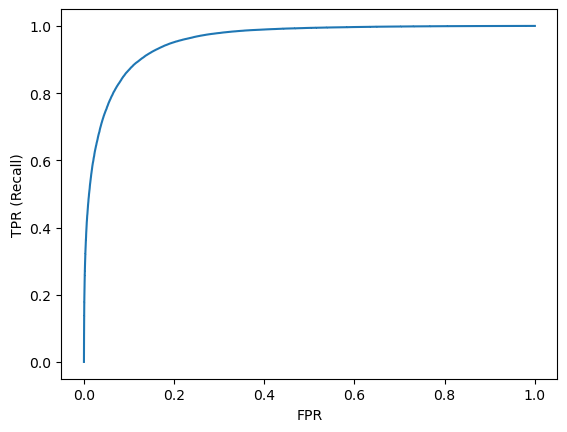

AUC: 0.96


In [33]:
# roc curve for top tagging 
fpr, tpr, thresholds = roc_curve(y_train[:, 0], y_train_pred[:, 0])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.show()
print(f"AUC: {auc(fpr, tpr):.2f}")